In [17]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

df=pd.read_csv("heart_data.csv")
df.head(5)

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [18]:
#Checking for any null values
print(df.isnull().sum())

index          0
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [19]:
#Converting age in days to age in yrs
df['age'] = np.floor(df['age'] / 365.25).astype(int)
#Creating BMI column using existing weight(Kg) and height(cm) column
df['BMI'] = df['weight'] / ((df['height']/100) ** 2)

df.head(5)

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,4,4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [20]:
#Checking for neg values in datasets
def check_neg(column_to_check):
  negative_count = (df[column_to_check] < 0).sum()
  print("Count of negative values in column '{}': {}".format(column_to_check, negative_count))

for col in df.columns:
  check_neg(col)

Count of negative values in column 'index': 0
Count of negative values in column 'id': 0
Count of negative values in column 'age': 0
Count of negative values in column 'gender': 0
Count of negative values in column 'height': 0
Count of negative values in column 'weight': 0
Count of negative values in column 'ap_hi': 7
Count of negative values in column 'ap_lo': 1
Count of negative values in column 'cholesterol': 0
Count of negative values in column 'gluc': 0
Count of negative values in column 'smoke': 0
Count of negative values in column 'alco': 0
Count of negative values in column 'active': 0
Count of negative values in column 'cardio': 0
Count of negative values in column 'BMI': 0


In [21]:
#sorting the df acc to age
df.sort_values(by='age', ascending=True, inplace=True)

#interpolate the negative ap_lo and ap_high with previous person who has similar age
df['ap_lo'] = df['ap_lo'].mask(df['ap_lo'] < 0, other=pd.NA)
df['ap_hi'] = df['ap_hi'].mask(df['ap_hi'] < 0, other=pd.NA)

df['ap_lo'] = df.groupby('age')['ap_lo'].transform(lambda x: x.interpolate(method='nearest'))
df['ap_hi'] = df.groupby('age')['ap_hi'].transform(lambda x: x.interpolate(method='nearest'))


for col in df.columns:
  check_neg(col)

Count of negative values in column 'index': 0
Count of negative values in column 'id': 0
Count of negative values in column 'age': 0
Count of negative values in column 'gender': 0
Count of negative values in column 'height': 0
Count of negative values in column 'weight': 0
Count of negative values in column 'ap_hi': 0
Count of negative values in column 'ap_lo': 0
Count of negative values in column 'cholesterol': 0
Count of negative values in column 'gluc': 0
Count of negative values in column 'smoke': 0
Count of negative values in column 'alco': 0
Count of negative values in column 'active': 0
Count of negative values in column 'cardio': 0
Count of negative values in column 'BMI': 0


In [22]:
#unique value
print(df.nunique())

index          70000
id             70000
age               28
gender             2
height           109
weight           287
ap_hi            148
ap_lo            156
cholesterol        3
gluc               3
smoke              2
alco               2
active             2
cardio             2
BMI             3808
dtype: int64


**Analysis of datasets**

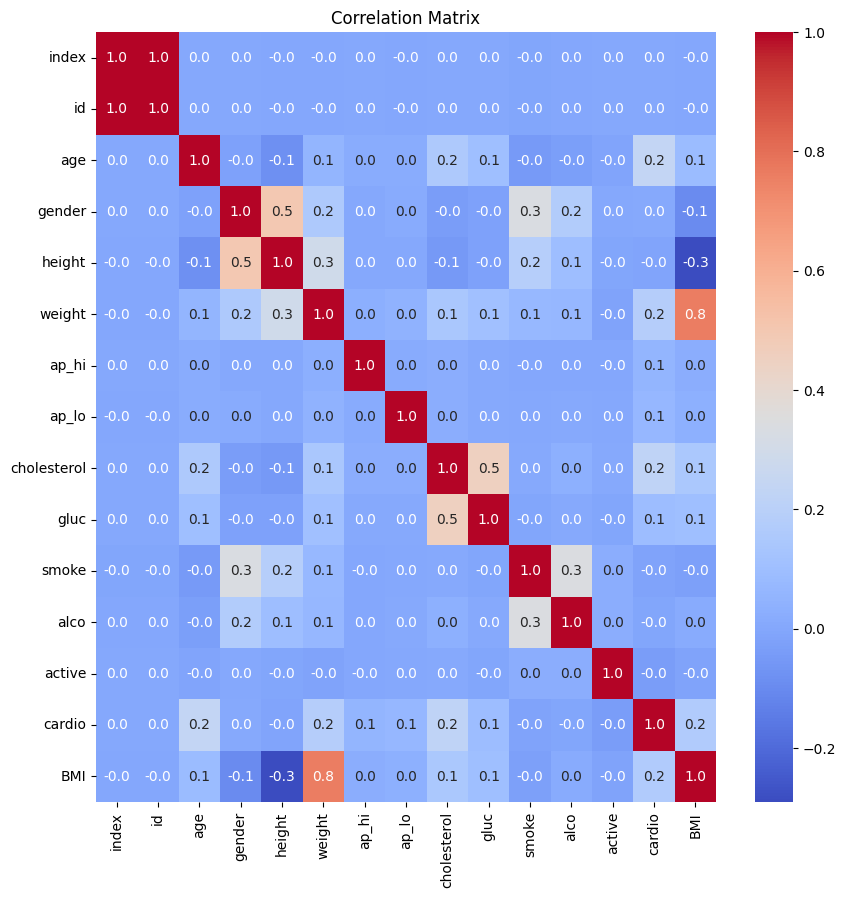

In [23]:
#Creating correlation matrix to measure statistical dependence of each feature.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Correlation Matrix')
plt.show()

**Key Insights:**


*  ap_hi and ap_lo (Blood Pressure): These two variables have a perfect correlation (1.0), because they both represent blood pressure readings. This suggest that including both may lead to redundancy in the model; so we have consider to combine them in some meaningful way.
*  weight and BMI: There’s a strong positive correlation (0.8), as BMI is directly calculated using weight and height. This shows that weight is a significant determinant of BMI.
*  cholesterol and gluc (Blood Glucose): There’s a moderate positive correlation (0.5), indicating that high cholesterol is often associated with higher blood glucose levels, which is consistent with known cardiovascular risk factors. Both of these could be important for predicting cardiovascular disease.
*  gender and height: There is a noticeable correlation between gender and height (0.5). This might be due to biological differences in average heights between genders but may not be directly relevant to cardiovascular disease prediction.
*  height and BMI: There is a weak negative correlation (-0.3) between height and BMI. This relationship suggests that, on average, taller individuals may have slightly lower BMI values for a given weight compared to shorter individuals. Although weak, this negative correlation reflects that height inversely affects BMI when weight remains constant.



<Axes: ylabel='count'>

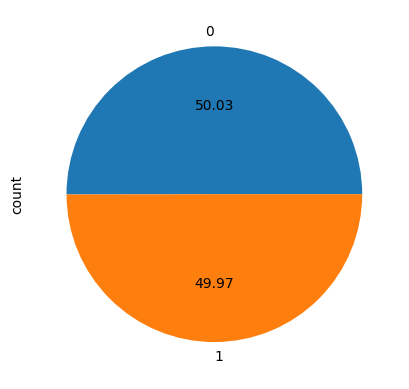

In [42]:
df['cardio'].value_counts().plot(kind='pie',autopct='%.2f')

With approximately 49.97% of individuals with cardiovascular conditions or high cardiovascular risk, indicates a fairly balanced distribution between those at risk and those not at risk.So this dataset has a  balanced target variable which can be advantageous in predictive modeling as it reduces the risk of bias toward one class over the other.

<Axes: ylabel='count'>

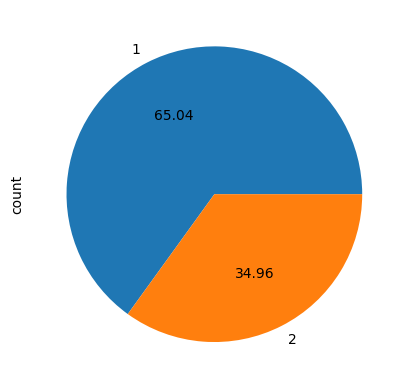

In [43]:
df['gender'].value_counts().plot(kind='pie',autopct='%.2f')

The above pie chart is a skewed gender distribution, with a significantly higher proportion of males. This skewed ratio can impact the interpretation of risk factors, as certain cardiovascular risk factors may differ. For instance, lifestyle or biological factors might make some features more relevant predictors for one gender compared to the other.

(array([    0.,     0., 70000.,     0.,     0.]),
 array([-0.5, -0.3, -0.1,  0.1,  0.3,  0.5]),
 <BarContainer object of 5 artists>)

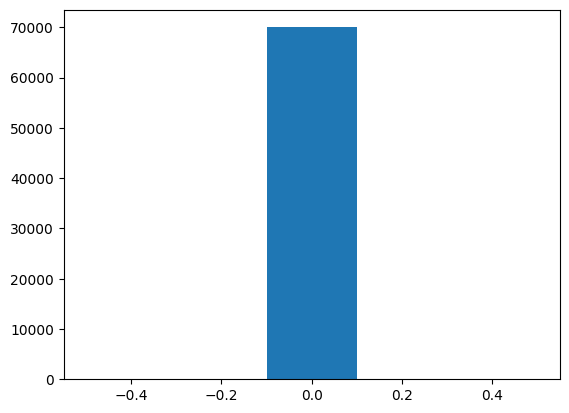

In [44]:
plt.hist(df['age'],bins=5)

C:\Users\divya\AppData\Local\Temp\ipykernel_24480\974756348.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['alco'].mean().reset_index()


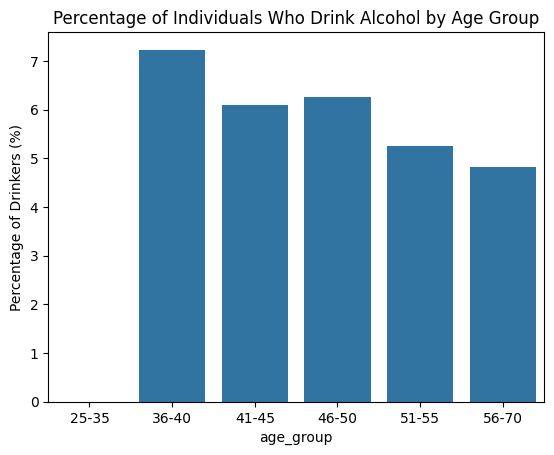

In [24]:
bins = [25, 35, 40, 45, 50, 55, 70]
labels = ['25-35', '36-40', '41-45', '46-50', '51-55', '56-70']

# Create a new column for age groups
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Calculate the percentage of drinkers by age group
percentage_df = df.groupby('age_group')['alco'].mean().reset_index()
percentage_df['percentage'] = percentage_df['alco'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of Drinkers (%)')
plt.title('Percentage of Individuals Who Drink Alcohol by Age Group')
plt.show()

C:\Users\divya\AppData\Local\Temp\ipykernel_644\1568024372.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['smoke'].mean().reset_index()


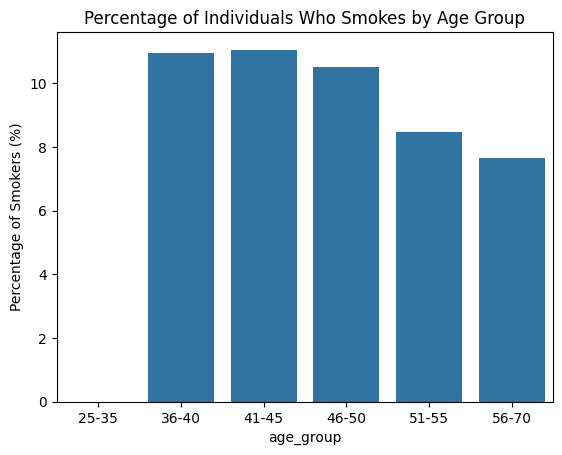

In [56]:
# Calculate the percentage of smokers by age group
percentage_df = df.groupby('age_group')['smoke'].mean().reset_index()
percentage_df['percentage'] = percentage_df['smoke'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of Smokers (%)')
plt.title('Percentage of Individuals Who Smokes by Age Group')
plt.show()

Insight: Individuals belonging to the age group 36-40 are constitute the highest percentage of smokers and alcohol drinkers. This is likely due to greater amount of stess levels that individuals at this age group are exposed to, which leads to them relying on external stimulants as stress relievers. Such individuals are at a risk for CVD in the next few years depending on the level of their consumption. 

C:\Users\divya\AppData\Local\Temp\ipykernel_644\367981338.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['cholesterol'].mean().reset_index()


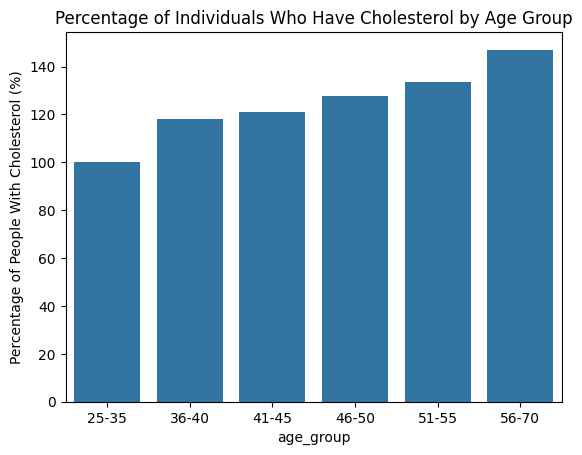

In [57]:
# Calculate the percentage of Cholestrol by age group
percentage_df = df.groupby('age_group')['cholesterol'].mean().reset_index()
percentage_df['percentage'] = percentage_df['cholesterol'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of People With Cholesterol (%)')
plt.title('Percentage of Individuals Who Have Cholesterol by Age Group')
plt.show()
df.drop(['age_group'], axis=1,inplace=True)

Insight: There is a steady increase in the cholestrol level of individuals as the age group is increasing, which ultimately increases their risk of getting CVD.

C:\Users\divya\AppData\Local\Temp\ipykernel_644\2362365007.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_df = df.groupby('age_group')['active'].mean().reset_index()


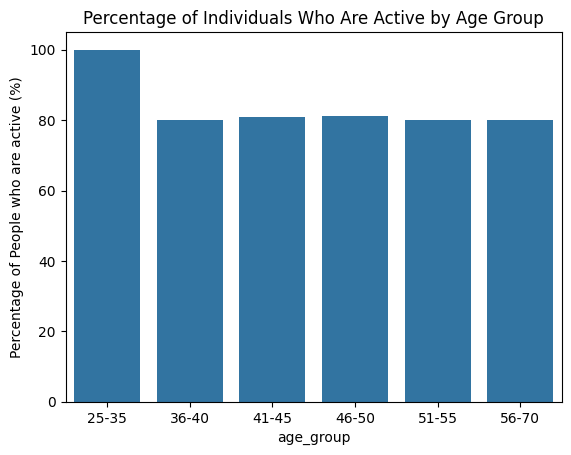

In [59]:
# Create a new column for age groups
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Calculate the percentage of drinkers by age group
percentage_df = df.groupby('age_group')['active'].mean().reset_index()
percentage_df['percentage'] = percentage_df['active'] * 100  # Convert to percentage

# Plotting
sns.barplot(x='age_group', y='percentage', data=percentage_df)
plt.ylabel('Percentage of People who are active (%)')
plt.title('Percentage of Individuals Who Are Active by Age Group')
plt.show()

Insight: It is observed that the younger generation, particularly the age group 25-35, is more active as compared to the older generations. This can also be one of the reasons why they are less likely to be affected by cardiovascular diseases at their age.

<Axes: xlabel='age', ylabel='Count'>

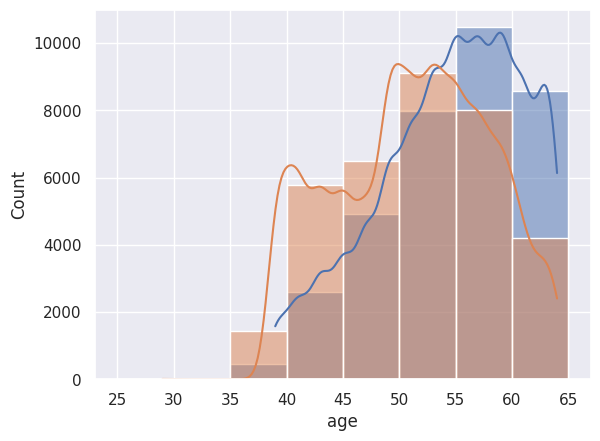

In [34]:
sns.set_theme()
sns.histplot(df[df['cardio'] == 1]['age'], bins=range(25, 66, 5), kde=True) #Blue
sns.histplot(df[df['cardio'] == 0]['age'], bins=range(25, 66, 5), kde=True)  #Orange

The KDE line smooths out the distribution and gives a visual representation of the underlying probability density function of the age distribution.
It helps you see the overall trend of age distribution.
Interpretation:
Since the bar for the age range 55-60 is the tallest, we can conclude that the highest number of individuals with the cardio condition falls within that age range.
The KDE line shows a peak in a certain age range, it indicates that this age group has a higher density of individuals with the cardio condition,
suggesting potential age-related patterns in cardiovascular health.

In [35]:
df.describe()

,index,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,34999.500000,49972.419900,52.803257,1.349571,164.359229,74.205690,128.842157,96.632843,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513
std,20207.403759,28851.302323,6.762462,0.476838,8.210126,14.395757,153.991179,188.471478,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511
min,0.000000,0.000000,29.000000,1.000000,55.000000,10.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,17499.750000,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,34999.500000,50001.500000,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068
75%,52499.250000,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222
max,69999.000000,99999.000000,64.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667


**Dectecting Outlier**

Z-scoring Technique

In [36]:
df['age'].describe()

,age
count,70000.000000
mean,52.803257
std,6.762462
min,29.000000
25%,48.000000
50%,53.000000
75%,58.000000
max,64.000000


<Axes: ylabel='age'>

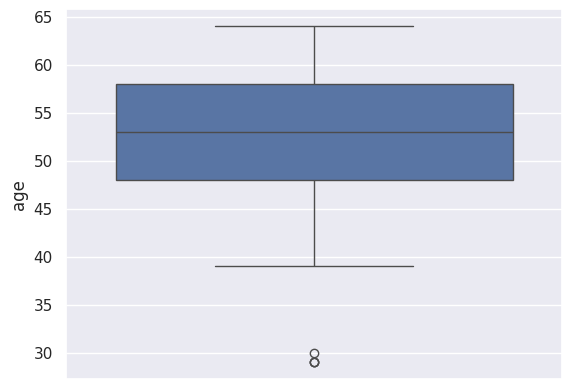

In [37]:
sns.boxplot(df['age'])

In [38]:
df['height'].describe()

,height
count,70000.000000
mean,164.359229
std,8.210126
min,55.000000
25%,159.000000
50%,165.000000
75%,170.000000
max,250.000000


<Axes: ylabel='height'>

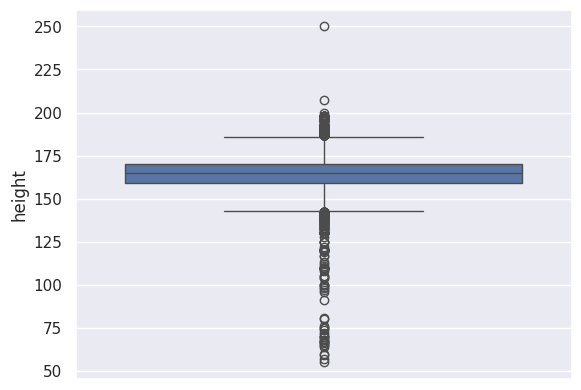

In [39]:
sns.boxplot(df['height'])

In [40]:
df['weight'].describe()

,weight
count,70000.000000
mean,74.205690
std,14.395757
min,10.000000
25%,65.000000
50%,72.000000
75%,82.000000
max,200.000000


<Axes: ylabel='weight'>

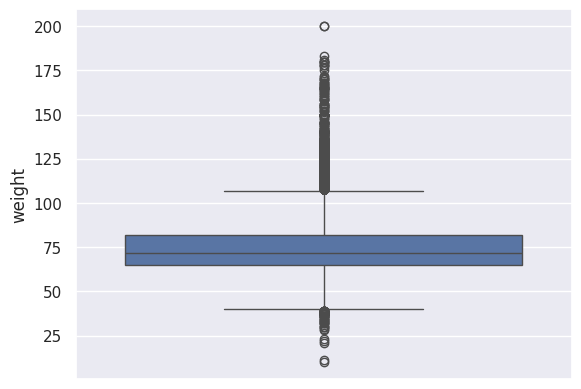

In [41]:
sns.boxplot(df['weight'])

In [45]:
df['ap_lo'].describe()

,ap_lo
count,70000.000000
mean,96.632843
std,188.471478
min,0.000000
25%,80.000000
50%,80.000000
75%,90.000000
max,11000.000000


In [53]:
df['ap_hi'].describe()

,ap_hi
count,70000.000000
mean,128.842157
std,153.991179
min,1.000000
25%,120.000000
50%,120.000000
75%,140.000000
max,16020.000000


In [43]:
column=['age','height','weight','ap_lo','ap_hi']
for cols in column:
    print(f"\n{cols}:")
    # Finding the boundary values
    high=df[cols].mean() + 3*df[cols].std();
    low=df[cols].mean() - 3*df[cols].std()
    print("Highest allowed",high)
    print("Lowest allowed",low)
    # Finding the outliers
    print(df[(df[cols] > high) | (df[cols] < low)])
# After doing so do triming: new_df = df[(df[cols] < high) & (df[cols] > low)] new_df


age:
Highest allowed 73.09064227828898
Lowest allowed 32.5158720074253
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
6219    6219   8850   29       1     175    59.0  120.0   80.0            1   
22343  22343  31922   29       2     175    92.0  100.0   60.0            1   
30666  30666  43842   29       1     159    59.0  120.0   80.0            1   
55905  55905  79749   30       1     160    59.0  110.0   70.0            1   

       gluc  smoke  alco  active  cardio        BMI  
6219      1      0     0       1       0  19.265306  
22343     1      0     0       1       0  30.040816  
30666     1      0     0       1       0  23.337684  
55905     1      0     0       1       0  23.046875  

height:
Highest allowed 188.98960766504325
Lowest allowed 139.72884947781387
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
36642  36642  52361   39       2     189    98.0  130.0   80.0            3   
36820  36820  52622   39  

InterQuartile Technique

In [51]:
column=['age','height','weight','ap_lo','ap_hi']
for cols in column:
    print(f"\n{cols}:")
    # Finding the IQR
    Q1= df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    print(f"25percentile: {Q1}")
    print(f"75percentile: {Q3}")
    iqr = Q3-Q1
    print(f"IQR: {iqr}")
    upper_limit = Q3 + 1.5 * iqr
    lower_limit = Q1 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    print(df[(df[cols] >= lower_limit) & (df[cols] <= upper_limit)])


age:
25percentile: 48.0
75percentile: 58.0
IQR: 10.0
Upper limit 73.0
Lower limit 33.0
       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
47373  47373  67661   39       1     168    61.0  100.0   80.0            1   
62801  62801  89674   39       2     182    62.0  130.0   60.0            1   
16802  16802  24010   39       1     155    54.0  120.0   80.0            1   
62781  62781  89645   39       2     168    70.0  120.0   80.0            1   
21482  21482  30691   39       2     167    72.0  110.0   70.0            1   
...      ...    ...  ...     ...     ...     ...    ...    ...          ...   
52939  52939  75519   64       1     162   110.0  140.0   90.0            3   
16318  16318  23314   64       1     166    68.0  140.0   90.0            3   
61161  61161  87316   64       1     152    70.0  170.0   80.0            1   
52740  52740  75241   64       1     170    76.0  120.0   80.0            1   
27304  27304  39043   64       1     160   

Creating a column for hypertension and categorizing people

In [26]:
def classify_blood_pressure(row):
    systolic = row['ap_hi']
    diastolic = row['ap_lo']

    if systolic < 120 and diastolic < 80:
        return 'Normal'
    elif 120 <= systolic <= 129 and diastolic < 80:
        return 'Elevated'
    elif 130 <= systolic <= 139 or (80 <= diastolic <= 89):
        return 'Hypertension Stage 1'
    elif systolic >= 140 or diastolic >= 90:
        return 'Hypertension Stage 2'
    elif systolic > 180 or diastolic > 120:
        return 'Hypertensive Crisis'
    else:
        return 'Unknown'  # In case of any unexpected values

# adding hypertension column
df['Hypertension'] = df.apply(classify_blood_pressure, axis=1)

print(df.head(10))

       index     id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  \
22343  22343  31922   29       2     175    92.0  100.0   60.0            1   
6219    6219   8850   29       1     175    59.0  120.0   80.0            1   
30666  30666  43842   29       1     159    59.0  120.0   80.0            1   
55905  55905  79749   30       1     160    59.0  110.0   70.0            1   
54580  54580  77862   39       1     172   132.0  145.0   80.0            1   
26839  26839  38369   39       1     158    65.0  110.0   90.0            1   
2049    2049   2899   39       2     169    68.0  110.0   80.0            1   
67980  67980  97090   39       1     146    83.5  120.0   80.0            1   
107      107    142   39       2     164    48.0  110.0   70.0            1   
51418  51418  73325   39       2     171    70.0  120.0   80.0            1   

       gluc  smoke  alco  active  cardio        BMI age_group  \
22343     1      0     0       1       0  30.040816     25-35   


Pie charts for visualzing various stages of hypertension across both genders

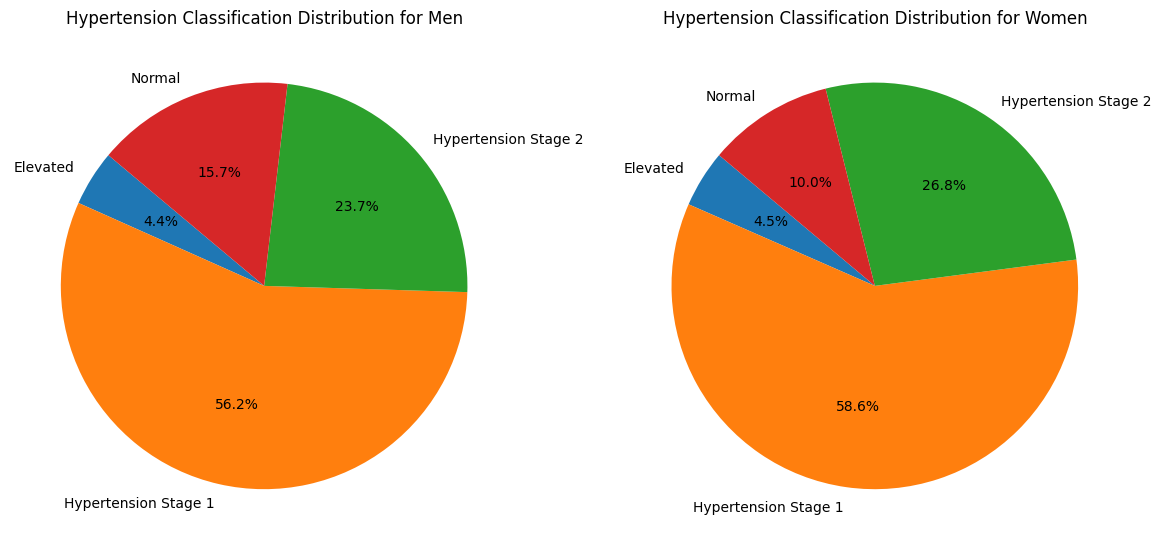

In [27]:
hypertension_counts = df.groupby(['gender', 'Hypertension']).size().unstack()

plt.figure(figsize=(12, 6))

# Creating a pie chart for each gender
for i, gender in enumerate(hypertension_counts.index):
    gender_label = "Women" if gender == 2 else "Men"  
    plt.subplot(1, 2, i + 1)
    plt.pie(hypertension_counts.loc[gender], labels=hypertension_counts.columns, autopct='%1.1f%%', startangle=140)
    plt.title(f'Hypertension Classification Distribution for {gender_label}')

plt.tight_layout()
plt.show()

Insight: According to the pie charts, we can conclude that women have greater percentage of Hypertension Stage 1 cases as compared to men. They also have more Hypertnesion Stage 2 cases as compared to men. This increases their chances of getting cardiovascular diseases by a narrow margin.

C:\Users\divya\AppData\Local\Temp\ipykernel_24480\4118002623.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hypertension_distribution = df.groupby(['age_group', 'gender', 'Hypertension']).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

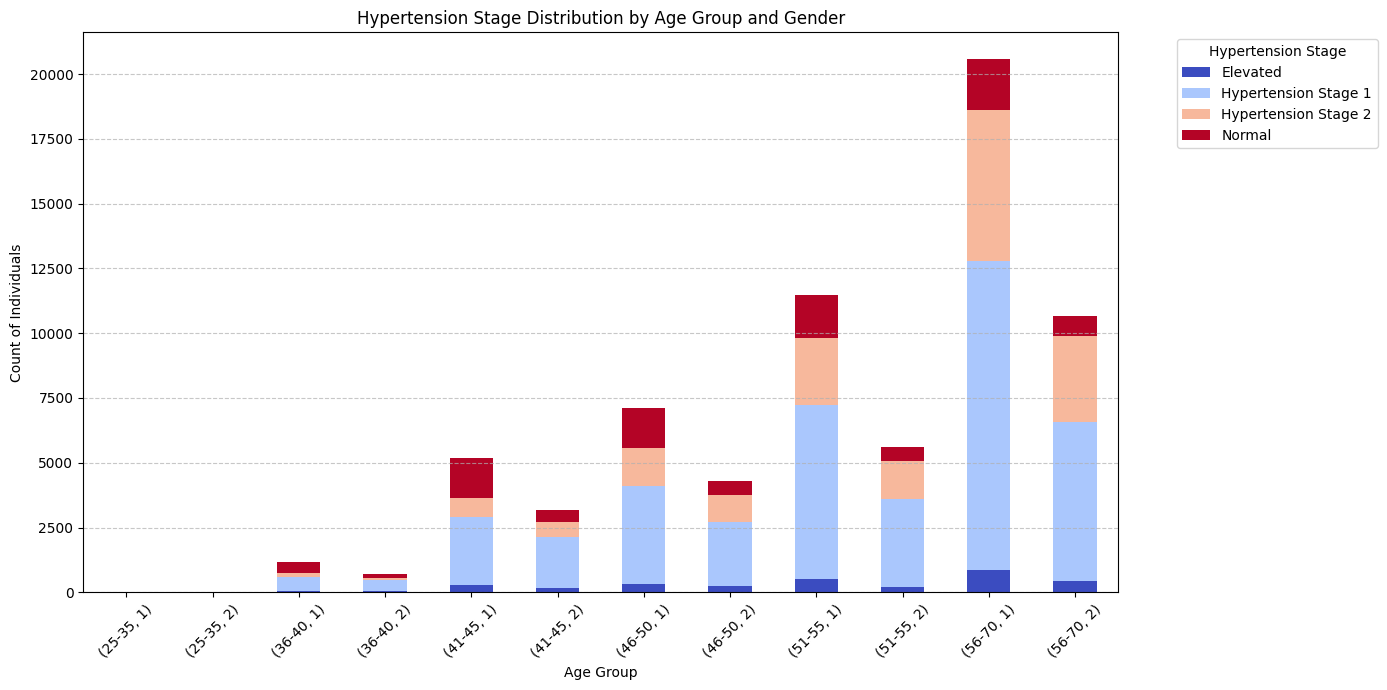

In [28]:

bins = [25, 35, 40, 45, 50, 55, 70]
labels = ['25-35', '36-40', '41-45', '46-50', '51-55', '56-70']

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

hypertension_distribution = df.groupby(['age_group', 'gender', 'Hypertension']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
hypertension_distribution.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(14, 7))

plt.title('Hypertension Stage Distribution by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Count of Individuals')
plt.legend(title='Hypertension Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Insight: The prevalence of hypertension increases with age. This is evident from the increasing height of the stacked bars as we move from younger to older age groups.
The number of individuals in the normal category decreases with age, while the number in the elevated and hypertension stages increases.
In the younger age groups (25-35, 36-40), the majority are still in the normal category.
Starting from the 41-45 age group, we see a significant increase in the number of individuals in the elevated and hypertension stages.
The 56-70 age group has the highest number of individuals in the hypertension stage 2 category.

The increasing prevalence of hypertension with age could be due to various factors like lifestyle changes (e.g., diet, exercise), genetic predisposition, and age-related physiological changes.